# 第12組_社群媒體分析_期末專案_主題模型

## 組別：Group 12
## 題目：PTT論壇AI相關議題的語料分析與趨勢探勘
### 使用工具：Python

M134020005 馮祐倫  
M134020051 柯昆霖

報告影片連結：https://youtu.be/NcM5DaE0uTg


## 目的
2023 年起，生成式 AI 帶來了前所未有的變革浪潮。從 ChatGPT 到 Midjourney、從人工到自動化，AI 正以前所未有的速度滲透人們的工作與生活。  
而在台灣最具代表性的網路論壇之一——PTT，鄉民們也開始熱烈討論這波浪潮帶來的機會與焦慮。

本專案計畫分析和說明以下三個核心問題：

1. PTT 社群如何看待 AI 在職場與科技工作的角色與影響？

2. 各主要實體（如：公司、技術、人物等）在討論中扮演什麼樣的網絡位置與影響力？

3. 不同主題下的情緒傾向與輿論熱點為何？


透過各種不同的分析，進一步揭示各實體在社群中的連結強度、討論中心性與潛在社群結構：

1. 情緒分析 (Sentiment Analysis)

    目的：判斷貼文中對 AI 的整體情感傾向（正向、中立、負向）。

    應用：了解網友對 AI 技術、AI 應用在工作上，以及 AI 對職場未來影響的情緒態度，並進一步探索情緒隨時間或議題的變化趨勢。

2. 主題模型分析 (Topic Modeling)

    目的：藉由 BERTopic 方法，自動挖掘貼文中的主題結構，找出幾大核心討論議題。

    應用：了解在「AI+工作」範疇內，網友最關注哪些面向（例如「AI 自動化取代工作」、「AI 招募面試應用」、「AI 技能學習建議」……），並分析每個主題的情緒分佈與實體共現情況。

3. 命名實體識別 (NER)

    目的：自動偵測並抽取貼文中的組織（ORG）、人物（PERSON）、產品（PRODUCT）、技術（TECH）等實體。

    應用：辨識出在 AI 討論中最常被提及的公司（如台積電、NVIDIA）、研究單位、意見領袖，或是關鍵技術名詞，為後續網路圖與主題建模提供實體基礎。

4. 網路圖構建 (Network Graph Analysis)

    目的：將貼文中的實體 (經由 NER) 與關鍵詞或使用者互動關係視覺化為節點與邊，構建實體共現網路或使用者互動網路。

    應用：揭示 AI 議題中各實體之間的關聯強度（例如哪些公司或技術一起被討論最多）、意見領袖的社群結構，以及不同主題或情緒社群的網絡分布。


綜合以上，能更立體地描繪出台灣論壇使用者在 AI 職場議題中的討論趨勢、關注焦點與情緒反應。



## 資料集概覽

此資料集收集自台灣的社群媒體平台 PTT。  
PTT「工作」、「職場」、「科技工作」三個版中，針對含有 “AI” 關鍵字的貼文。  
資料收集範圍從 2024 年 5 月 1 日到 2025 年 5 月 1 日，共包含 2456 筆資料。

## 資料欄位說明

資料集包含以下 10 個欄位：

1. `system_id`: 系統編號
2. `artComment`: 文章評論
3. `artDate`: 文章日期
4. `insertedDate`: 插入日期
5. `artContent`: 文章內容
6. `artCatagory`: 文章類別
7. `dataSource`: 資料來源
8. `artPoster`: 發文者
9. `artTitle`: 文章標題。
10. `artUrl`: 文章網址

### 載入套件

In [1]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus
import re
import pyLDAvis
import pyLDAvis.gensim_models
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Heiti TC']  # macOS 的中文系統字型
plt.rcParams['axes.unicode_minus'] = False         # 正常顯示負號

In [ ]:
df = pd.read_csv('Merged.csv', encoding='utf-8')
# df["artDate"] = pd.to_datetime(df["artDate"])
# df['artDate'] = df['artDate'].dt.date

# 嘗試自動轉換日期，不合法的會變成 NaT
df["artDate"] = pd.to_datetime(df["artDate"], errors='coerce')

# 移除無法轉換為日期的列
df = df[df["artDate"].notna()]

# 把 datetime 轉成純日期（不含時間）
df["artDate"] = df["artDate"].dt.date



clear_df = df.copy()
#去除本次不會用到的欄位
drop_cols = ['system_id', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource']
clear_df.drop(drop_cols, axis = 1, inplace = True)
#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)
#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','', regex=True)
#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].str.replace(r'http\S+', '', regex=True).str.replace(r'www\S+', '', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode('sentence').reset_index(drop=True)
# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]
sent_df['sentence'] = sent_df['sentence'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

# sampled_df = sent_df.sample(n=100, random_state=222)


In [5]:
sent_df.shape

(86950, 5)

In [6]:
sent_df.head()

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,很明顯絕對會
1,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,我之前面試時就遇過
2,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,而且明擺著開太高不會用你
3,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,前陣子業界很凍現在好像也
4,https://www.ptt.cc/bbs/Tech_Job/M.1714553434.A...,Re:[面試]104待遇寫4w~4.8w你應該開多少？,2024-05-01,很明顯絕對會，我之前面試時就遇過，而且明擺著開太高不會用你。\n\n前陣子業界很凍（現在好像...,我又剛好快畢業了整個人充滿求職焦慮所以上只要我覺得可以做的工作就投不管那家公司在哪叫什麼知名...


### 斷詞

In [7]:
docs_zh = sent_df['sentence'].tolist()[:3000]

# 設定繁體中文詞庫
jieba.set_dictionary('dict/dict.txt.big')

# 新增 stopwords
with open('dict/stop_words.txt',encoding="utf-8") as f:
    stopwords = [line.strip() for line in f.readlines()]

# 定義一個適合中文的分詞函數
def tokenize_zh(text):
    words = jieba.lcut(text)
    return words

### 初次 Auto 分類結果

In [ ]:
# 中文文章
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from hdbscan import HDBSCAN


###-- Embedding --###

# 設定中文 embedding model
bert_sentence_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# 將中文文章轉換為 embedding
embeddings = bert_sentence_model.encode(docs_zh, show_progress_bar=True)


###-- BERTopic --###

# 定義不同 clustering layer 所要使用的模型與方法（就用 default 的 DBSCAN）
hdbscan_model = HDBSCAN(
    min_cluster_size=30,    # 如果一個群集裡的文件少於 30 篇，就會被視為噪音，不列為獨立主題。
    min_samples=10,         # 一個點若要被算作核心點，就必須在它周圍有至少 10 個鄰居點。數值愈大，群集會更穩固，但也可能忽略掉邊緣一點的文件。
    metric="euclidean"      # 歐氏距離
)

# 建立一個使用 jieba 分詞的 CountVectorizer
jieba_vectorizer = CountVectorizer(
    tokenizer=tokenize_zh, 
    stop_words=stopwords,
    min_df=5, # 只保留至少出現在 5 篇文件中的詞，減少雜訊
    max_df=0.8, # 排除出現在超過 80% 文件的詞
    analyzer='word',
    token_pattern=u"(?u)\\b\\w+\\b")

# 使用 BERTopic 進行主題模型建立
zh_topic_model = BERTopic(
    embedding_model=bert_sentence_model, 
    vectorizer_model=jieba_vectorizer, 
    verbose=True, 
    top_n_words=30,
    nr_topics="auto" #最終要幾個主題
    )

topics, probs = zh_topic_model.fit_transform(docs_zh, embeddings)

zh_topic_model.get_topic_info()

2025-06-12 13:32:57,524 : INFO : Use pytorch device_name: mps
2025-06-12 13:32:57,525 : INFO : Load pretrained SentenceTransformer: paraphrase-multilingual-MiniLM-L12-v2


Batches:   0%|          | 0/94 [00:00<?, ?it/s]

2025-06-12 13:33:05,283 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2025-06-12 13:33:12,289 - BERTopic - Dimensionality - Completed ✓
2025-06-12 13:33:12,290 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-12 13:33:12,333 - BERTopic - Cluster - Completed ✓
2025-06-12 13:33:12,333 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
Building prefix dict from /Users/kunlin/Documents/NSYSU_中山大學/113-2 課程/MIS581_社群媒體分析/期末專案/dict/dict.txt.big ...
2025-06-12 13:33:12,336 : DEBUG : Building prefix dict from /Users/kunlin/Documents/NSYSU_中山大學/113-2 課程/MIS581_社群媒體分析/期末專案/dict/dict.txt.big ...
Loading model from cache /var/folders/jl/rs16gbqd5bz6g1r6y4xjtp480000gn/T/jieba.ued0918e487b7bbaf03783db14d036714.cache
2025-06-12 13:33:12,337 : DEBUG : Loading model from cache /var/folders/jl/rs16gbqd5bz6g1r6y4xjtp480000gn/

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1059,-1_公司_成長_問題_工程師,"[公司, 成長, 問題, 工程師, 產品, 廠, 中, 工作, 華碩, 做, 技術, 日, ...","[全球第一大半導體封裝與測試製造大廠日月光高雄廠人資副總李叔霞在人力銀行徵才直播節目中表示,..."
1,0,357,0_晶片_人工智慧_科技_技術,"[晶片, 人工智慧, 科技, 技術, 市場, 半導體, 員工, 客戶, 產業, 工作, 公司...","[誰在為人工智慧製造晶片, 他們開發出了第一款無需人工輸入的人工智慧設計晶片, 科技公司會為..."
2,1,240,1_指出_表示_黃_目前,"[指出, 表示, 黃, 目前, 能夠, 仁勳, 人類, 最近, 希望, 做, 現在, 次, ...","[施崇棠致詞指出, 報導指出, 黃崇仁指出]"
3,2,136,2_面試_主管_過程_感覺,"[面試, 主管, 過程, 感覺, 小, 態度, 最後, 兩個, 時, 要求, 問題, 準備,...","[面試心得線上面試, 跟我說還有一個主管要下來面試, 第一關就是大主管面試]"
4,3,121,3_中國_資料_使用_美國,"[中國, 資料, 使用, 美國, 新創, 產業, 透過, 半導體, 團隊, 人, 電腦, 訓...","[中國發現自己越來越孤立, 中國四家獨角獸的崛起, 中國仍然落後美國至少五到十年]"
5,4,96,4_知道_找_說_之後,"[知道, 找, 說, 之後, 自我介紹, 內容, 影響, 覺得, 準備, 合作, 看到, 直...","[我是不知道究竟還有什麼在米國的意義, 說我不會找你們這樣的公司來合作, 很想直接說抱歉我不..."
6,5,88,5_萬_美元_約_超過,"[萬, 美元, 約, 超過, 今年, 簽署, 月, 新創, 達, 投資, 新, 人, 微軟,...","[比起上份工作他的年薪加了萬美元約萬人民幣, 變身為市值兆美元約新台幣兆元大企業, 年薪約萬]"
7,6,75,6_一年_年_去年_過去,"[一年, 年, 去年, 過去, 今年, 傳統, 建議, 以來, 表現, 一直, 裁員, 相信...","[去年年中, 在這一年內, 全都在這一年關門大吉]"
8,7,73,7_單位_股價_美國_美元,"[單位, 股價, 美國, 美元, 影響, 吃, 來說, 應該, 比較, 方案, 一點, 考慮...","[台積電股價實在太便宜, 其股價實在太過便宜, 台商豬屎屋底薪應該只有下列情況可以贏了發哥全..."
9,8,69,8_研究_資料_已經_正在,"[研究, 資料, 已經, 正在, 顯示, 指出, 目前, 中, 認為, 資訊, 負責, 能夠...","[一項研究預估聲稱, 根據的研究追蹤, 我印象中李飛飛教授年就已經開始在關注的相關數據研究了]"


In [9]:
zh_topic_model.visualize_topics()

### 手動主題設置

In [21]:
eleven_topic =BERTopic(
    embedding_model=bert_sentence_model, 
    vectorizer_model=jieba_vectorizer, 
    verbose=True, 
    top_n_words=30,
    nr_topics=10 # 最終要幾個主題
    )
ele_topics, ele_probs = eleven_topic.fit_transform(docs_zh, embeddings)


2025-06-12 15:55:23,366 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-12 15:55:28,712 - BERTopic - Dimensionality - Completed ✓
2025-06-12 15:55:28,725 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-12 15:55:28,794 - BERTopic - Cluster - Completed ✓
2025-06-12 15:55:28,795 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-06-12 15:55:28,939 - BERTopic - Representation - Completed ✓
2025-06-12 15:55:28,940 - BERTopic - Topic reduction - Reducing number of topics
2025-06-12 15:55:28,948 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-12 15:55:29,023 - BERTopic - Representation - Completed ✓
2025-06-12 15:55:29,025 - BERTopic - Topic reduction - Reduced number of topics from 65 to 10


In [ ]:
eleven_topic.visualize_topics()

- 左邊 - Topic 0 ,3 ,4 ,7
- 中間 - Topic 2 ,6 
- 右邊 - Topic 1 ,5 ,8 

In [22]:
all_topics = []

# 假設你有一個 BERTopic 模型：eleven_topic
for topic_num in range(len(eleven_topic.get_topics())):
    topic_terms = eleven_topic.get_topic(topic_num)
    if topic_terms:  # 有些主題可能為 None（如 -1 代表 outlier）
        topic_df = pd.DataFrame(topic_terms, columns=[f"Topic {topic_num}", "Weight"])
        all_topics.append(topic_df)

# 合併所有主題成一張橫向對齊的表格（視覺化用途）
from functools import reduce
combined_df = reduce(lambda left, right: pd.concat([left, right], axis=1), all_topics)

import pandas as pd
from IPython.display import display
display(combined_df)


,Topic 0,Weight,Topic 1,Weight,Topic 2,Weight,Topic 3,Weight,Topic 4,Weight,Topic 5,Weight,Topic 6,Weight,Topic 7,Weight,Topic 8,Weight
0,面試,0.108414,表示,0.229612,晶片,0.166171,中國,0.246563,美國,0.397791,英文,0.532352,約,0.258532,開發,0.297155,面試,0.564029
1,主管,0.096758,指出,0.210040,人工智慧,0.139948,晶片,0.071362,人才,0.090134,模型,0.325423,園區,0.219790,主要,0.297155,請,0.170132
2,年,0.069502,說,0.108222,科技,0.088725,美國,0.068921,需求,0.078773,大型,0.156639,全球,0.144103,部分,0.186191,業界,0.163826
3,公司,0.058364,已經,0.092267,技術,0.082595,使用,0.060721,時,0.074815,進行,0.090289,簽署,0.126833,開放,0.129172,以來,0.158379
4,市場,0.056919,想,0.077751,半導體,0.076298,新創,0.053245,發展,0.071438,透過,0.088620,代表,0.122616,產品,0.121003,模式,0.149313
5,工作,0.047697,目前,0.077238,先進,0.074142,半導體,0.053245,中,0.065703,要求,0.067134,台,0.122616,積極,0.111700,合作,0.130419
6,約,0.043875,中,0.071509,最,0.047530,中心,0.048955,提供,0.062860,需要,0.062660,基礎,0.118906,加入,0.111700,許多,0.125738
7,成長,0.042838,問題,0.064840,超級,0.041348,產業,0.048423,要求,0.059675,面試,0.057849,鴻海,0.118906,鴻海,0.111700,機會,0.123598
8,月,0.042003,最近,0.063381,一直,0.039932,前,0.047305,高,0.056914,推出,0.054382,積電,0.118906,軟體,0.108591,一直,0.123598
9,現在,0.039815,做,0.059548,產業,0.039031,透過,0.047119,研發,0.053505,做,0.041034,集團,0.115597,超級,0.108591,使用,0.117827


## LLM 評估分析

#### 概況

- Topic 0: 職涯發展與求職 (Career Development & Job Seeking)  
關鍵詞: 面試, 主管, 公司, 工作, 成長, 客戶
解讀: 這個主題非常清晰，圍繞著個人在職場的活動，包含面試、與主管和公司的互動、對工作的看法以及個人成長。

- Topic 1: 陳述與引述用語 (Statement & Quotation Language)  
關鍵詞: 表示, 指出, 說, 已經, 想, 目前
解讀: 這些詞本身主題意義不強，比較像是新聞報導、訪談或文章中用來引述觀點或描述狀態的「功能性」詞彙。在主題模型中，這類主題很常見，可以視為「語氣」或「文體」的集合。

- Topic 2: 晶片與半導體科技 (Chip & Semiconductor Technology)  
關鍵詞: 晶片, 人工智慧, 科技, 技術, 半導體, 先進
解讀: 這是一個高度聚焦於「硬科技」的主題，核心就是半導體、AI晶片等先進技術。

- Topic 3: 中美科技競爭 (US-China Tech Competition)  
關鍵詞: 中國, 晶片, 美國, 使用, 新創, 半導體, 產業
解讀: 這個主題明顯地描繪了地緣政治格局，特別是中國和美國在晶片、半導體產業上的競爭與動態。

- Topic 4: 美國科技發展與人才需求 (US Tech Development & Talent Demand)  
關鍵詞: 美國, 人才, 需求, 發展, 提供, 研發
解讀: 這個主題聚焦在「美國」的科技場景，特別是關於人才的需求、發展趨勢以及研發狀況。可以視為 Topic 3 的一個分支，但更專注於美國內部。

- Topic 5: 大型 AI 模型與相關技能 (Large AI Models & Related Skills)  
關鍵詞: 英文, 模型, 大型, 進行, 透過, 要求, 面試
解讀: 模型 和 大型 幾乎可以確定是指「大型語言模型 (LLM)」。而 英文、要求、面試 等詞暗示了討論的是開發或使用這些模型所需具備的技能和條件。

- Topic 6: 台灣科技產業與全球佈局 (Taiwan's Tech Industry & Global Operations)  
關鍵詞: 園區, 全球, 簽署, 代表, 台 (台灣), 鴻海, 積電, 集團
解讀: 這個主題的核心是台灣的科技巨頭（如鴻海、台積電）及其產業聚落（科學園區），以及它們在全球的佈局和合作。

- Topic 7: 產品與軟體開發 (Product & Software Development)  
關鍵詞: 開發, 產品, 軟體, 開放, 專案, 應用
解讀: 這個主題聚焦於「開發」的過程，包括軟體、產品、應用程式的開發，以及開放平台或專案合作的模式。

- Topic 8: 商業模式與產業合作 (Business Models & Industry Cooperation)  
關鍵詞: 面試, 業界, 模式, 合作, 機會, 客戶
解讀: 雖然 面試 權重最高，但結合 業界、模式、合作 來看，這裡的「面試」可能更偏向於高階的商業討論或策略會議。整個主題圍繞著產業趨勢、新的商業模式和合作機會。

#### 左邊群組（0,3,4,7）

Topic 0：面試、主管、年、公司、市場

Topic 3：中國、使用、新創、產業

Topic 4：美國、人才、需求、發展、時

Topic 7：開發、產品、專案、準備、軟體

這個分群圍繞「人」與「事」的宏觀與微觀層面。Topic 3 和 Topic 4 是宏觀的國際局勢，而 Topic 0 和 Topic 7 是微觀的個人與團隊活動。它們共同描繪了產業的「動態」。



#### 中間群組（2,6）


關鍵詞代表：

Topic 2：人工智慧、科技、技術、半導體、模型、超級

Topic 6：約、園區、全球、簽署、台灣、集團

這兩個主題完美地構成了「台灣科技業的核心」。一個是談「技術本身」（硬體科技），另一個是談「產業玩家」（台廠與其佈局）。這是整個語料庫最核心的骨幹。

#### 右邊群組（1,5,8）

關鍵詞代表：

Topic 1：表示、指出、說、目前、問題、新

Topic 5：英文、模型、大型、進行、開放、說

Topic 8：面試、請、業界、以來、使用、客戶

這個分群的內部關聯性稍弱一些。Topic 1 是功能性詞彙，比較像噪音。Topic 5 是非常具體的「AI 模型」，而 Topic 8 則是較抽象的「商業策略」。

In [ ]:
# 中文文章
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from hdbscan import HDBSCAN


###-- Embedding --###

# 設定中文 embedding model
bert_sentence_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# 將中文文章轉換為 embedding
embeddings = bert_sentence_model.encode(docs_zh, show_progress_bar=True)


###-- BERTopic --###

# 定義不同 clustering layer 所要使用的模型與方法（就用 default 的 DBSCAN）
hdbscan_model = HDBSCAN(
    min_cluster_size=30,    # 如果一個群集裡的文件少於 30 篇，就會被視為噪音，不列為獨立主題。
    min_samples=10,         # 一個點若要被算作核心點，就必須在它周圍有至少 10 個鄰居點。數值愈大，群集會更穩固，但也可能忽略掉邊緣一點的文件。
    metric="euclidean"      # 歐氏距離
)

# 建立一個使用 jieba 分詞的 CountVectorizer
jieba_vectorizer = CountVectorizer(
    tokenizer=tokenize_zh, 
    stop_words=stopwords,
    min_df=5, # 只保留至少出現在 5 篇文件中的詞，減少雜訊
    max_df=0.8, # 排除出現在超過 80% 文件的詞
    analyzer='word',
    token_pattern=u"(?u)\\b\\w+\\b")

# 使用 BERTopic 進行主題模型建立
zh_topic_model = BERTopic(
    embedding_model=bert_sentence_model, 
    vectorizer_model=jieba_vectorizer, 
    verbose=True, 
    top_n_words=30,
    nr_topics="auto" #最終要幾個主題
    )

topics, probs = zh_topic_model.fit_transform(docs_zh, embeddings)

zh_topic_model.get_topic_info()

In [ ]:
from gensim.models import LdaModel
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# 設定主題數範圍
topic_range = range(2, 21)  # 試 2~20 題
coherence_scores = []

for num_topics in topic_range:
    lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
    coherence_model = CoherenceModel(model=lda, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model.get_coherence()
    coherence_scores.append(coherence)
    print(f"num_topics={num_topics}, coherence={coherence:.4f}")


In [23]:
topic_distr, _ = eleven_topic.approximate_distribution(docs_zh)

100%|██████████| 3/3 [00:00<00:00,  8.11it/s]


In [24]:
eleven_topic.visualize_distribution(topic_distr[1])


上圖為第 2 篇文章的主題分布結果。該貼文主要聚焦在「面試經驗」、「主管互動」等職場場景（Topic 8 與 Topic 0），其次提及了國際趨勢（Topic 4），但與產品開發的關聯度較低（Topic 7）。

這樣的分布顯示該文章具備明確的核心主題，但也帶有少量跨主題討論。

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/opt/anaconda3/envs/SMA/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning:

backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.

/opt/anaconda3/envs/SMA/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning:

backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.

/opt/anaconda3/envs/SMA/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning:

backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



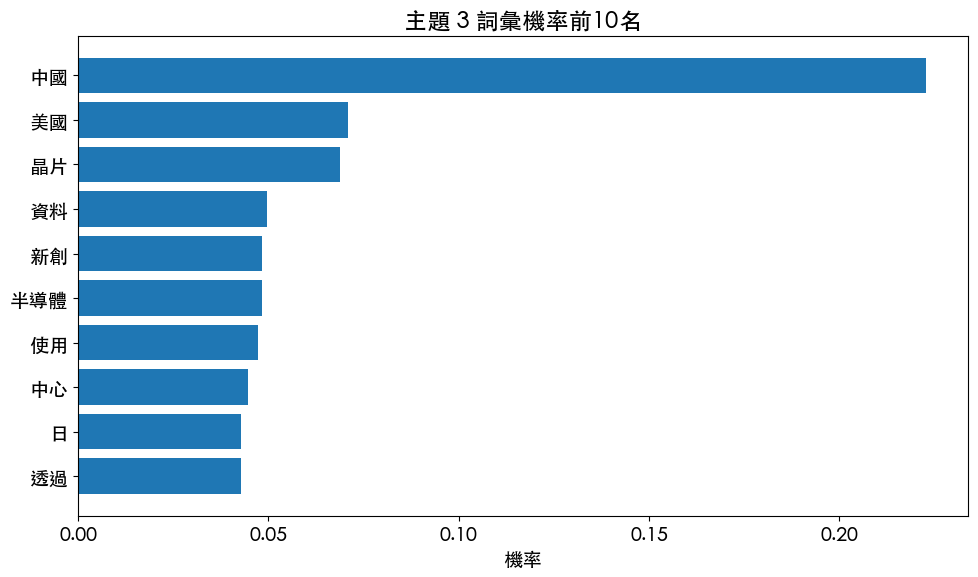

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import font_manager


#    下面這行會列出所有可用字體名稱，找出正確的字體名稱（通常是 'Microsoft JhengHei'）
for font in font_manager.findSystemFonts(fontpaths=None, fontext='ttf'):
    if "JhengHei" in font:
        print(font_manager.FontProperties(fname=font).get_name())


# 3. （可選）設定字體大小
plt.rcParams['font.size'] = 14

# 範例：繪製主題詞條長條圖
topic_n = 3
data = eleven_topic.get_topic(topic_n)

import pandas as pd
df = pd.DataFrame(data, columns=['word', 'prob'])
df = df[df['word'].str.strip()!=' ']
top_10 = df.sort_values('prob', ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.barh(top_10['word'], top_10['prob'])
plt.xlabel('機率')
plt.title(f'主題 {topic_n} 詞彙機率前10名')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
